# Test For First Version Of `pydrift` 

We're going to test how it works with the famous titanic dataset

# Dependencies

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

from pydrift.core.drift_checker import DataDriftChecker
from pydrift.constants import PATH_DATA, RANDOM_STATE

# Read Data 

In [2]:
df_titanic = pd.read_csv('../datasets/titanic.csv')

# Constants 

In [3]:
DATA_LENGTH = df_titanic.shape[0]
TARGET = 'Survived'

# Data Split

50% sample will give us a non-drift problem

In [4]:
X = df_titanic.drop(columns=['PassengerId', TARGET])
y = df_titanic[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.5, random_state=RANDOM_STATE, stratify=y
)

# Instanciate `pydrift.DataDriftChecker` 

In [5]:
data_drift_checker_ok = DataDriftChecker(X_train, X_test)

# Test  `ml_model_can_discriminate` Feature

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


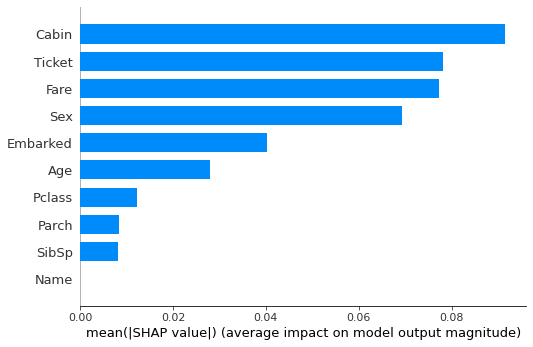

No drift found in discriminative model step

AUC drift check model: 0.47958291708291706
AUC threshold: 0.55


True

In [6]:
data_drift_checker_ok.ml_model_can_discriminate()

# Same But  Make It Drift

`pydrift` tells you that the problem is in `Sex` feature (as is obviously in this example)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


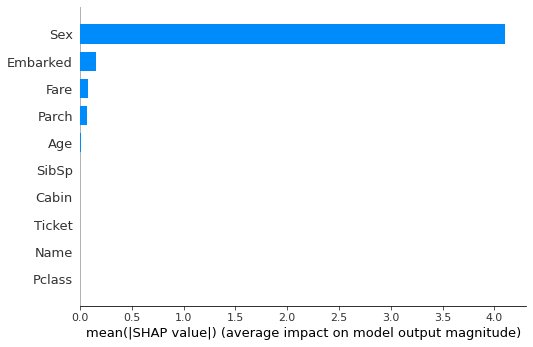

Drift found in discriminative model step, take a look on the most discriminative features (plots when minimal is set to False)

AUC drift check model: 1.0
AUC threshold: 0.55


False

In [7]:
X_women = X[X['Sex'] == 'female']
X_men = X[X['Sex'] == 'male']

data_drift_checker_ko = DataDriftChecker(X_women, X_men)
data_drift_checker_ko.ml_model_can_discriminate()